In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [170]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [171]:
df = pd.concat([df_train_obs_A,df_train_est_A])
df = df.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [172]:
df.isna().sum(), df.shape

(absolute_humidity_2m:gm3             24
 air_density_2m:kgm3                  24
 ceiling_height_agl:m               6151
 clear_sky_energy_1h:J                24
 clear_sky_rad:W                      24
 cloud_base_agl:m                   2387
 dew_or_rime:idx                      24
 dew_point_2m:K                       24
 diffuse_rad:W                        24
 diffuse_rad_1h:J                     24
 direct_rad:W                         24
 direct_rad_1h:J                      24
 effective_cloud_cover:p              24
 elevation:m                          24
 fresh_snow_12h:cm                    24
 fresh_snow_1h:cm                     24
 fresh_snow_24h:cm                    24
 fresh_snow_3h:cm                     24
 fresh_snow_6h:cm                     24
 is_day:idx                           24
 is_in_shadow:idx                     24
 msl_pressure:hPa                     24
 precip_5min:mm                       24
 precip_type_5min:idx                 24
 pressure_100m:h

In [173]:
df['ceiling_height_agl:m'].describe()

count    27934.000000
mean      2974.149133
std       2564.641899
min         27.849998
25%       1126.050000
50%       1978.900000
75%       4174.150000
max      12294.901000
Name: ceiling_height_agl:m, dtype: float64

In [174]:
df['cloud_base_agl:m'].describe()

count    31698.000000
mean      1728.923473
std       1807.137823
min         27.800000
25%        582.918750
50%       1150.162500
75%       2084.781250
max      11673.625000
Name: cloud_base_agl:m, dtype: float64

250 means settled snow

In [175]:
df['snow_density:kgm3'].describe()

count    1140.0
mean      250.0
std         0.0
min       250.0
25%       250.0
50%       250.0
75%       250.0
max       250.0
Name: snow_density:kgm3, dtype: float64

In [176]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [177]:
df_nandrop = df
df_nandrop = df_nandrop.drop(columns= ['snow_densitykgm3'],axis = 1)
df_nandrop = df_nandrop.dropna()

df_nan0 = df.fillna(0)
df_nanmedian = df.fillna(df.median())
df_rolling2 = df.fillna(df.rolling(2).mean())
df_rolling4 = df.fillna(df.rolling(720).mean())

In [178]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Imputa i valori mancanti
df_knn =pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [179]:
df_dict = {
    'nan':df,
    'drop' : df_nandrop,
    'zero' : df_nan0,
    'median' : df_nanmedian,
    'knn' : df_knn,
    'rolling2' : df_rolling2,
    'rolling4' : df_rolling4,
}

In [180]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3
# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

In [181]:
import lightgbm as lgb
param = {'verbose' :-1}

model = lgb.LGBMRegressor(**param)

In [182]:
def test(df_dict):
    mean_mae_list = []
    for key in df_dict:
        print(key)
        data = df_dict[key]
        maelist = []
        for train_index, test_index in tscv.split(data):
            train_data = data.iloc[train_index]
            test_data = data.iloc[test_index]

            # Extract target variable for training and testing data
            y_train = train_data['pv_measurement']
            y_test = test_data['pv_measurement']

            # Extract features for training and testing data
            X_train = train_data.drop(columns = 'pv_measurement')
            X_test = test_data.drop(columns = 'pv_measurement')

            # Train the XGBoost model
            model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model using Mean Absolute Error (MAE)
            mae = mean_absolute_error(y_test, y_pred)
            print("Mean Absolute Error:", mae)
            maelist.append(mae)
        # Return MAE
        mean_mae = np.average(maelist,weights=[1,2,3])
        print("Mean MAE: ",mean_mae )
        mean_mae_list.append(mean_mae)
    return mean_mae_list

In [183]:
test(df_dict)

nan
Mean Absolute Error: 226.060213393433
Mean Absolute Error: 198.99612725717907
Mean Absolute Error: 192.46365603252025
Mean MAE:  200.24057266755867
drop
Mean Absolute Error: 243.60612056525966
Mean Absolute Error: 205.26797439820447
Mean Absolute Error: 191.66291954886827
Mean MAE:  204.85513800137892
zero
Mean Absolute Error: 224.97592067579524
Mean Absolute Error: 200.71542122835228
Mean Absolute Error: 194.37340234648647
Mean MAE:  201.5878283619932
median
Mean Absolute Error: 226.04145522432125
Mean Absolute Error: 200.4419415696115
Mean Absolute Error: 194.9832019709297
Mean MAE:  201.97915737938888
knn
Mean Absolute Error: 223.19331177215196
Mean Absolute Error: 198.97744281281123
Mean Absolute Error: 193.66461855451942
Mean MAE:  200.35700884355546
rolling2
Mean Absolute Error: 226.060213393433
Mean Absolute Error: 198.99612725717907
Mean Absolute Error: 192.46365603252025
Mean MAE:  200.24057266755867
rolling4
Mean Absolute Error: 226.060213393433
Mean Absolute Error: 198.9

[200.24057266755867,
 204.85513800137892,
 201.5878283619932,
 201.97915737938888,
 200.35700884355546,
 200.24057266755867,
 200.24057266755867]

In [184]:
columns = df_rolling4.drop(columns = 'pv_measurement').columns


In [185]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Crea un oggetto MinMaxScaler
scaler = MinMaxScaler()

# Normalizza il DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df_rolling2[columns]),columns = df_rolling2[columns].columns, index = df_rolling2[columns].index)
df_normalized['pv_measurement'] = df_rolling4[ 'pv_measurement']

In [186]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Crea un oggetto StandardScaler
scaler = StandardScaler()

# Standardizza il DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df_rolling2[columns]),columns = df_rolling2[columns].columns, index = df_rolling2[columns].index)
df_scaled['pv_measurement'] = df_rolling4[ 'pv_measurement']

In [187]:
def z_score_standardization(data):
  mean = np.mean(data)
  std = np.std(data)
  standardized_data = (data - mean) / std
  return standardized_data

def z_score_standardization_dataframe(df):
    standardized_df = pd.DataFrame()
    for column in df.columns:
        standardized_df[column] = z_score_standardization(df[column])
    return standardized_df

# Esempio di utilizzo della funzione:

df_zscore = df_rolling2[columns]

df_zscore = z_score_standardization_dataframe(df_zscore)
df_zscore['pv_measurement'] = df_rolling4[ 'pv_measurement']

In [188]:
df_scaled_norm = {
    'norm' : df_normalized,
    'scaled' : df_scaled,
    'zscore' : df_zscore,
}

In [189]:
test(df_scaled_norm)

norm
Mean Absolute Error: 225.58002032045815
Mean Absolute Error: 197.41867945069134
Mean Absolute Error: 193.68892364188426
Mean MAE:  200.2473583579156
scaled
Mean Absolute Error: 226.78366529021184
Mean Absolute Error: 199.10849704688923
Mean Absolute Error: 195.08377257675673
Mean MAE:  201.70866285237676
zscore
Mean Absolute Error: 226.78366529021184
Mean Absolute Error: 199.10836617795113
Mean Absolute Error: 195.00550965538517
Mean MAE:  201.66948776871163


[200.2473583579156, 201.70866285237676, 201.66948776871163]

<Axes: xlabel='date_forecast'>

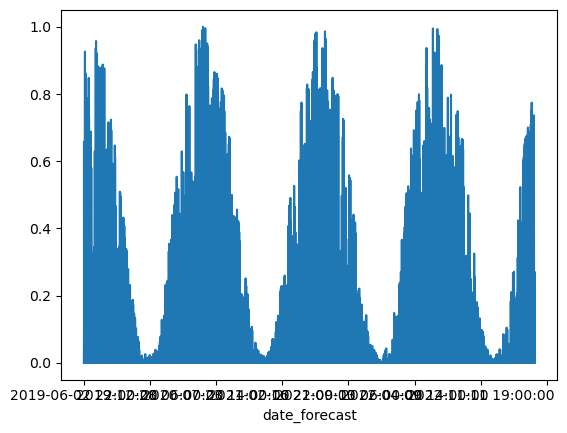

In [190]:
df_normalized['direct_radW'].plot()

<Axes: xlabel='date_forecast'>

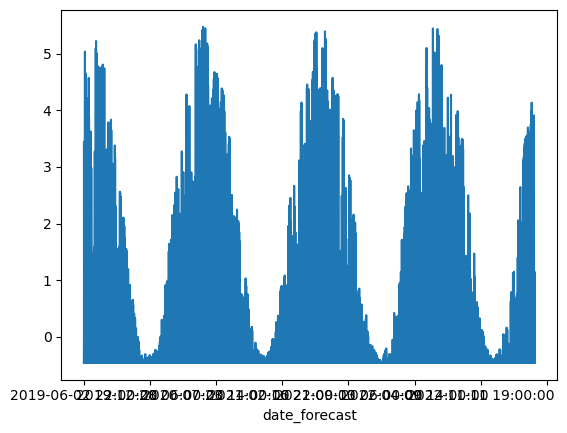

In [191]:
df_scaled['direct_radW'].plot()

<Axes: xlabel='date_forecast'>

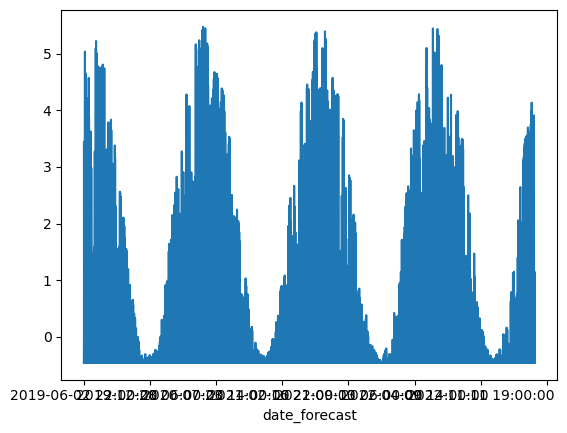

In [192]:
df_zscore['direct_radW'].plot()